## 1. 数据与预处理

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 设置超参数
num_epochs = 5
batch_size = 512
learning_rate = 0.001

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# 加载MNIST数据集
train_dataset = torchvision.datasets.MNIST(
    root = './data/', train = True, transform=transforms.ToTensor(), download=False)
test_dataset = torchvision.datasets.MNIST(
    root = './data/', train = False, transform=transforms.ToTensor(), download=False)

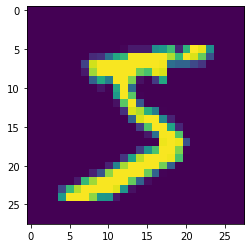

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.data[0])

In [6]:
# 配置Data loader，一次训练载入一个batch_size的数据集
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size, shuffle = False)

## 2. 神经网络搭建

In [7]:
class BPNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(BPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3(x)
        
        return x

In [11]:
model = BPNet().to(device)

## 3. 定义损失函数和优化器

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 4. 模型训练与测试

### 4.1. 模型训练

In [13]:
total_step = len(train_loader)
Loss = []
# 每一次迭代
for epoch in range(num_epochs):
    # 每一批次数据集
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device); labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {: .4f}".format(
                epoch+1, num_epochs, i+1, total_step, loss.item())
            )
        Loss.append(loss.item())

Epoch [1/5], Step [100/118], Loss:  2.2952
Epoch [2/5], Step [100/118], Loss:  2.2906
Epoch [3/5], Step [100/118], Loss:  2.2852
Epoch [4/5], Step [100/118], Loss:  2.2821
Epoch [5/5], Step [100/118], Loss:  2.2788


### 4.2. 测试模型效果

In [14]:
model.eval()
pred_prob0 = []
true_label = []
with torch.no_grad():
    correct = 0; total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device); labels = labels.to(device)
        outputs = model(images)
        probs = nn.Softmax(dim=1)(outputs)
        pred_prob0.extend(probs[:,0].tolist())
        true_label.extend(labels.tolist())
        predicted = torch.max(probs, 1).indices
        # _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(
        "Test Accuracy of the model on the 10000 test images:{} %".format(
            100 * correct / total)
    )

Test Accuracy of the model on the 10000 test images:16.07 %


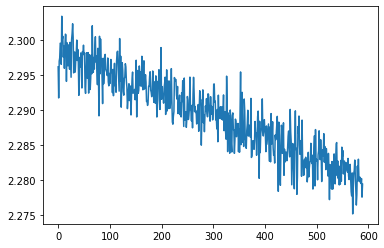

In [18]:
plt.plot(Loss)

In [15]:
ture0 = true_label
for i, label in enumerate(true_label):
    if label == 0:
        ture0[i] = 1
    else:
        ture0[i] = 0

In [16]:
from sklearn.metrics import roc_curve, auc

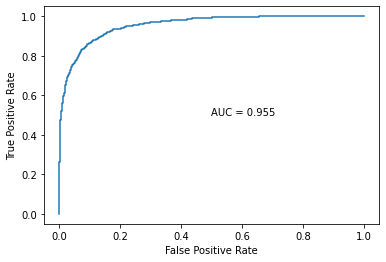

In [17]:
fpr, tpr, thresholds = roc_curve(ture0, pred_prob0)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

roc_auc = auc(fpr, tpr)
plt.text(0.5, 0.5, 'AUC = {:.3f}'.format(roc_auc))

plt.show()